<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

## Подготовка данных

In [1]:
#импорт библиотек

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

In [2]:
#загрузка данных с сохранением даты как индекса

data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
#проверка монотонности индекса

data.index.is_monotonic

True

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
#ресемплирование по одному часу

data = data.resample('1H').sum()

## Анализ

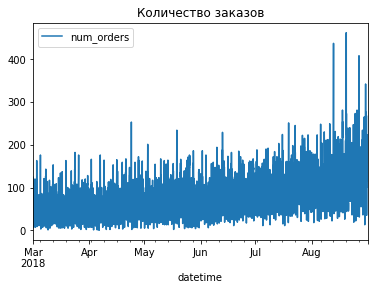

In [6]:
#построение общего графика количества заказов

data.plot()
plt.title(u'Количество заказов');

In [7]:
#выполнение декомпозиции

decomposed = seasonal_decompose(data)

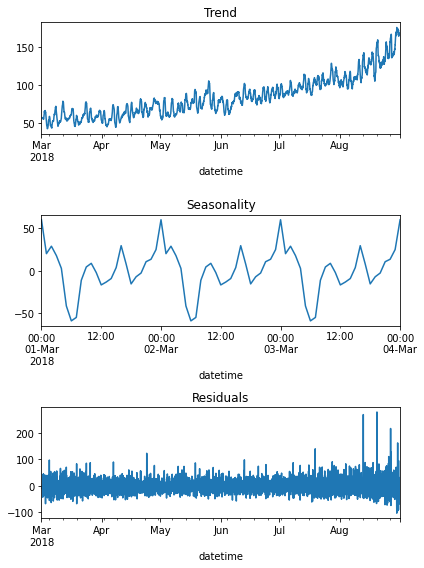

In [8]:
plt.figure(figsize=(6, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

#график сезонности для наглядности ограничен 3-мя днями
plt.subplot(312)
decomposed.seasonal['2018-03-01 00:00:00':'2018-03-04 00:00:00'].plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Можем заметить общий тренд на рост количества заказов за полгода и суточную сезонность, где пик в 0:00 и минимум в точке около 6:00, поэтому в признаки будет добавлено 6 предыдущих значений, и значение 24 часа назад. Также, ля признаков выбрано скользящее среднее, вычисляемое по предыдущим суткам, для отслеживания общего тренда.

In [9]:
#создание признаков

data['month'] = data.index.month
data['day'] = data.index.day
data['dayofweek'] = data.index.dayofweek
data['hour'] = data.index.hour

for lag in range(1, 6):
    data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
data['lag_24'] = data['num_orders'].shift(24)
data['rolling_mean'] = data['num_orders'].shift().rolling(24).mean()

## Обучение

In [10]:
#выделение тестовой выборки в размере 10% 

train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [11]:
#определение размера валидационной выборки по размеру тестовой

tscv = TimeSeriesSplit(n_splits = 8)

In [12]:
#скоринг линейной регресси

model = LinearRegression()
nrmse = cross_val_score(model, features_train, target_train, scoring='neg_root_mean_squared_error', cv=tscv)
print('RMSE линейной регрессии на кросс-валидации', nrmse.mean()*-1)

RMSE линейной регрессии на кросс-валидации 27.05700169026445


In [13]:
#подбор параметров случайного леса

model_2 = RandomForestRegressor()
parameters = {'n_estimators' : sp_randInt(50, 1000),
              'max_depth'    : sp_randInt(3, 12) 
             }
randm_src = RandomizedSearchCV(model_2, param_distributions=parameters, scoring='neg_root_mean_squared_error', cv=tscv, n_iter=10, n_jobs=-1, random_state=12345)
randm_src.fit(features_train, target_train)
print("Лучшие параметры для случайного леса:", randm_src.best_params_)

Лучшие параметры для случайного леса: {'max_depth': 10, 'n_estimators': 424}


In [14]:
#скоринг случайного леса с подобранными параметрами

model_2 = RandomForestRegressor(max_depth=randm_src.best_params_['max_depth'], n_estimators=randm_src.best_params_['n_estimators'], n_jobs=-1, random_state=12345)
nrmse_2 = cross_val_score(model_2, features_train, target_train, scoring='neg_root_mean_squared_error', cv=tscv)
print('RMSE случайного леса на кросс-валидации', nrmse_2.mean()*-1)

RMSE случайного леса на кросс-валидации 24.88115917829562


Были рассмотрены модели линейной регрессии и случайного леса. Метрика качества оказалась лучше у второй модели.

## Тестирование

In [15]:
model_2.fit(features_train, target_train)
pred = model_2.predict(features_test)
result = mean_squared_error(target_test, pred) ** 0.5
print('RMSE лучшей модели на тестовой выборке', result)

RMSE лучшей модели на тестовой выборке 46.282854709474584
